In [ ]:
%reset -f
# Gait Quality Score con Autoencoders y Sliding Windows

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
import matplotlib.pyplot as plt

# === Paso 1: Cargar dataset ===
filePath = './GaitData/gait.csv'
df = pd.read_csv(filePath)

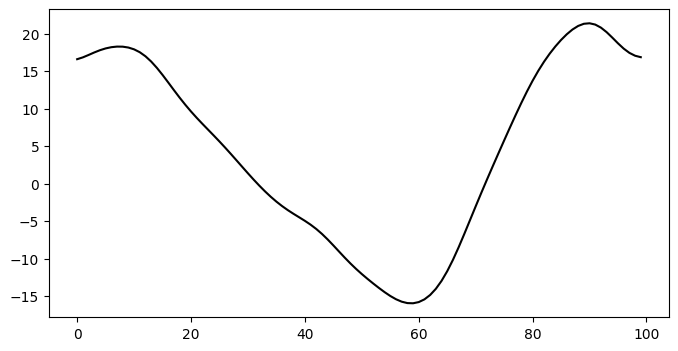

In [ ]:
# === Paso 2: Preparar datos de todas las articulaciones ===
joint_map = {1: 'ankle', 2: 'knee', 3: 'hip'}
data_by_joint = {}
scalers = {}
holdout_by_joint = {}  
holdout_subjects = [9, 10] # sujetos excluidos del entrenamiento

for joint_id, joint_name in joint_map.items():
    df_joint_all = df[(df['joint'] == joint_id) & (df['condition'] == 1)]  # solo marcha normal
    df_train = df_joint_all[~df_joint_all['subject'].isin(holdout_subjects)] # datos de entrenamiento
    df_hold  = df_joint_all[df_joint_all['subject'].isin(holdout_subjects)] # datos de validación

    #MATRIZ DE ENTRENAMIENTO
    grouped = df_train.groupby(['subject', 'replication', 'leg']) # agrupa por sujeto, repetición y pierna
    series_list = [] 
    for _, group in grouped: #crea las series temporales
        series = group.sort_values('time')['angle'].values
        if len(series) >= 100:
            series_list.append(series[:100]) # solo cien puntos
    X = np.stack(series_list) # matriz de series temporales (entrenamiento)

    #MATRIZ DE VALIDACIÓN
    series_list_hold = [] 
    for _, group in df_train.groupby(['subject', 'replication', 'leg']): 
        series = group.sort_values('time')['angle'].values
        if len(series) >= 100:
            series_list_hold.append(series[:100]) # solo cien puntos
    X_hold = np.stack(series_list_hold) if series_list_hold else None # matriz de series temporales 
                                                                        #(validacion, si existen)
    
    scaler = StandardScaler()
    data_by_joint[joint_name] = X
    scalers[joint_name] = scaler
    holdout_by_joint[joint_name] = X_hold

plt.figure(figsize=(8, 4))
plt.plot(X[0], color='black') # gráfico de prueba (primera serie del último conjunto procesado)


In [ ]:
# === Paso 3: Entrenar autoencoders por articulación ===
from keras.callbacks import EarlyStopping
models = {}

for joint_name, X in data_by_joint.items():
    input_dim = X.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu', activity_regularizer=regularizers.l1(1e-5))(encoded)
    
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    model = Model(inputs=input_layer, outputs=decoded)
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X, X,
          epochs=100,
          batch_size=16,
          shuffle=True,
          verbose=1,
          callbacks=[early_stop])
    
    models[joint_name] = model

# Calcular errores y definir umbral realista (media + 3*std)
error_distributions = {}

for joint_name, X in data_by_joint.items():
    model = models[joint_name]
    recon = model.predict(X, verbose=0)
    errors = np.mean((X - recon) ** 2, axis=1)
    
    err_min = float(np.percentile(errors, 0.5))     # más robusto que min()
    err_max = float(np.percentile(errors, 99.5))    # ignora outliers

    error_distributions[joint_name] = {
        "min": err_min,
        "max": err_max,
        "mean": float(np.mean(errors)),
        "std": float(np.std(errors))
    }

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 72.5774
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.0619 
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.2451 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.7265 
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8544 
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6262 
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3850 
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2397 
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6002 
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4396 
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1693 
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2829 
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6715 
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3059 
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

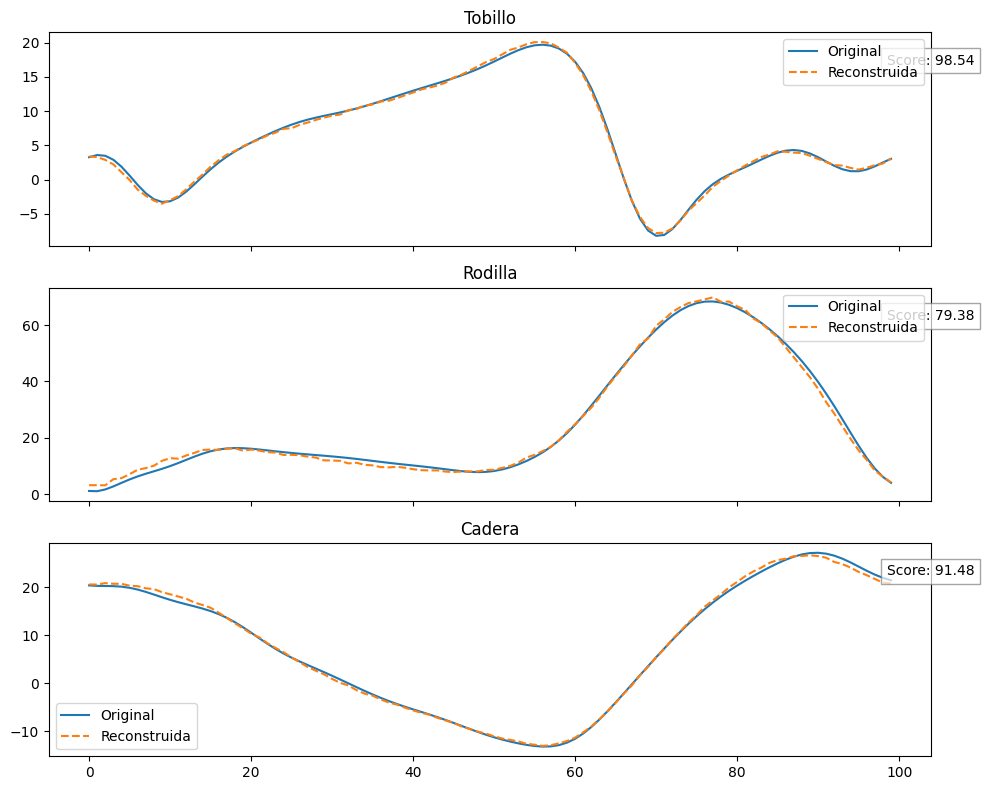

In [9]:
# === Paso 4: Evaluar señal con score normalizado ===
import random
subject_id = 5 #random.randint(1, 10)
df_test = pd.read_csv(filePath)
leg_id = 1
condition_id = 1  # por ejemplo marcha con férula
replication_id = 1
joint_scores = {}

scores = []
originalSignals = []
reconSignals = []
scoreStrings = []

for joint_id, joint_name in joint_map.items():
    df_joint = df_test[(df_test['joint'] == joint_id) &
                       (df_test['condition'] == condition_id) &
                       (df_test['subject'] == subject_id) &
                       (df_test['leg'] == leg_id) &
                       (df_test['replication'] == replication_id)]
    signal = df_joint.sort_values('time')['angle'].values[:100]
    model = models[joint_name]
    
    originalSignals.append(signal)
    signal = signal.reshape(1, -1)
    recon = model.predict(signal, verbose=0)
    reconSignals.append(recon[0])

    # Error y score normalizado
    error = np.mean((signal[0] - recon[0]) ** 2)
    err_min = error_distributions[joint_name]['min']
    err_max = error_distributions[joint_name]['max']
    log_error = np.log1p(error)
    log_err_min = np.log1p(err_min)
    log_err_max = np.log1p(6*err_max)

    score = 100 * (1 - (log_error - log_err_min) / (log_err_max - log_err_min))
    score = np.clip(score, 0, 100)

    scores.append(score)
    joint_scores[joint_name] = score
    scoreStrings.append(f"Score: {score:.2f}")

# === Gráfica ===
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
titles = ['Tobillo', 'Rodilla', 'Cadera']

for i in range(3):
    axs[i].plot(originalSignals[i], label='Original')
    axs[i].plot(reconSignals[i], label='Reconstruida', linestyle='--')
    axs[i].set_title(titles[i])
    axs[i].legend()
    axs[i].text(0.95, 0.9,
                scoreStrings[i],
                transform=axs[i].transAxes,
                ha='left', va='top',
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()


In [40]:
# === Paso 4: Evaluar señal larga con sliding windows ===
df_test = pd.read_csv(filePath)
subject_id = 1
leg_id = 1
condition_id = 3  # férula en rodilla
joint_scores = {}

for joint_id, joint_name in joint_map.items():
    df_joint = df_test[(df_test['joint'] == joint_id) &
                       (df_test['condition'] == condition_id) &
                       (df_test['subject'] == subject_id) &
                       (df_test['leg'] == leg_id)]
    signal = df_joint.sort_values('time')['angle'].values
    scaler = scalers[joint_name]
    model = models[joint_name]
    
    window_size = 100
    scores = []
    for i in range(0, len(signal) - window_size + 1, 100):
        window = signal[i:i + window_size]
        window = window.reshape(1, -1)  # forma (1, 100) para el modelo
        recon = model.predict(window, verbose=0)
        error = np.mean((window[0] - recon[0]) ** 2)
        error = np.mean((window - recon) ** 2)
        scores.append(error)
    
    joint_scores[joint_name] = scores

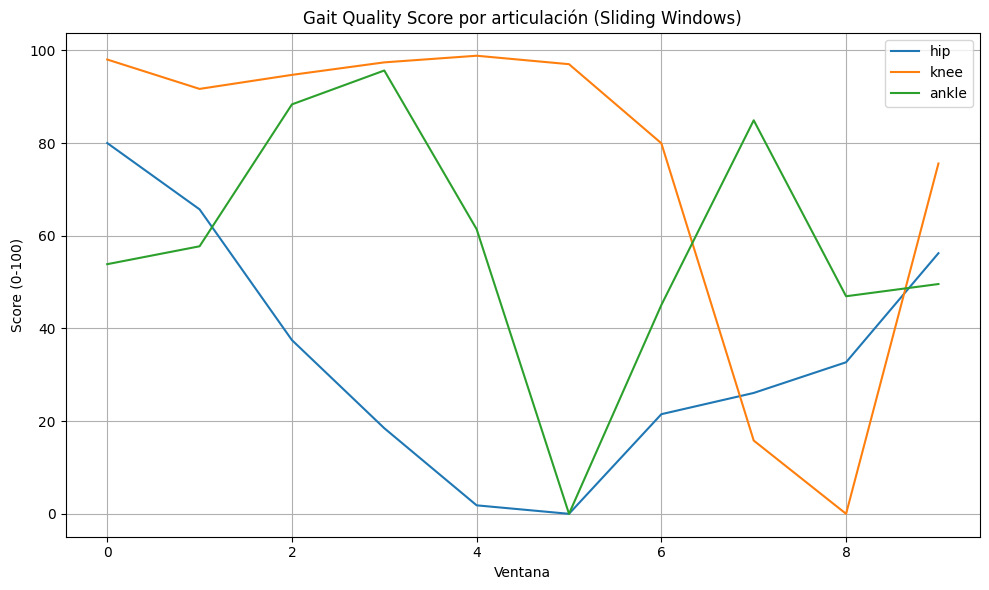

In [41]:
# === Paso 5: Graficar scores por articulación ===
plt.figure(figsize=(10, 6))
for joint_name, errors in joint_scores.items():
    norm_scores = 100 - (np.array(errors) / max(errors)) * 100
    norm_scores = np.clip(norm_scores, 0, 100)
    plt.plot(norm_scores, label=joint_name)

plt.title('Gait Quality Score por articulación (Sliding Windows)')
plt.xlabel('Ventana')
plt.ylabel('Score (0-100)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

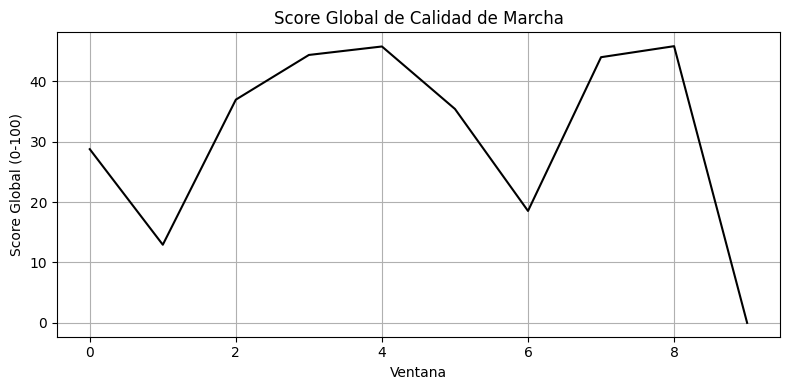

In [24]:
# === Paso 6: Score global ===
global_scores = [np.mean([joint_scores[j][i] for j in joint_scores]) for i in range(len(list(joint_scores.values())[0]))]
global_scores = 100 - (np.array(global_scores) / max(global_scores)) * 100
global_scores = np.clip(global_scores, 0, 100)

plt.figure(figsize=(8, 4))
plt.plot(global_scores, color='black')
plt.title('Score Global de Calidad de Marcha')
plt.xlabel('Ventana')
plt.ylabel('Score Global (0-100)')
plt.grid(True)
plt.tight_layout()
plt.show()
